### 0.import library and set configration

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import norm
# „Ç∞„É©„Éï„Çí„Ç§„É≥„É©„Ç§„É≥„ÅßË°®Á§∫„Åï„Åõ„Çã
import matplotlib.pyplot as plt
import japanize_matplotlib #Êó•Êú¨Ë™ûÂåñmatplotlib
%matplotlib inline

import seaborn as sns
sns.set(font="IPAexGothic") #Êó•Êú¨Ë™û„Éï„Ç©„É≥„ÉàË®≠ÂÆö

#from ydata_profiling import ProfileReport
import pickle


import warnings
# ÂÖ®„Å¶„ÅÆË≠¶Âëä„ÇíÁÑ°Ë¶ñ„Åô„Çã
warnings.filterwarnings("ignore")

In [2]:
#Ê©üÊ¢∞Â≠¶ÁøíÁî®„ÅÆ„É©„Ç§„Éñ„É©„É™„Ç§„É≥„Çπ„Éà„Éº„É´
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import lightgbm as lgb
import optuna
import shap
from imblearn.under_sampling import RandomUnderSampler


In [3]:
import geopandas as gpd


In [4]:
#import_original_function
from function.data_processing import test2
from function.data_processing import addtional_process
from function.modeling import objective

In [5]:
#pandas„ÅÆË°®Á§∫Ë®≠ÂÆö
# Ë°®Á§∫Âà∂Èôê„ÅÆÁ∑©Âíå
pd.set_option('display.max_columns', 300 )
pd.set_option('display.max_rows', 500 )
# ÊåáÊï∞Ë°®Ë®ò„ÅÆÁÑ°ÂäπÂåñ
pd.options.display.float_format = '{:.2f}'.format

In [6]:
#config„Éï„Ç°„Ç§„É´„ÅÆË™≠„ÅøËæº„Åø
import configparser
config_ini = configparser.ConfigParser()
config_ini.read('./config/config.ini', encoding='utf-8')

['./config/config.ini']

In [7]:
#read_file_congfig
test_file                = config_ini["INPUT_FILE"]["test_edited"]
train_file               = config_ini["INPUT_FILE"]["train_edited"]
deginition_file          = config_ini["CONFIG_FILE"]["deginition"]
submit_file              = config_ini["OUTPUT_FILE"]["submit"]
    
shap_plot_file           = config_ini["OUTPUT_FILE"]["shap_plot"]
predict_result_plot_file = config_ini["OUTPUT_FILE"]["predict_result_plot"]

model_file               = config_ini["OUTPUT_FILE"]["model"]
dbscan_model_file        = config_ini["OUTPUT_FILE"]["dbscan_model"]

#read_var_config
response_var             = config_ini["VAR"]["response_var"]


### 1.import_train/test_data


In [8]:
#„Éá„Éº„Çø„ÅÆÊàêÂûãÊñπÊ≥ï„ÇíË™≠Ëæº
df_deginition  = pd.read_excel(deginition_file,index_col=0, dtype = 'object',sheet_name = "data_deginition")
df_deginition  = df_deginition.query('Êé°Âê¶ == "‚óé"|Êé°Âê¶ == "„Äá"| Êé°Âê¶ == "‚ñ≥"')

#Â≠¶Áøí„Å´‰Ωø„ÅÜ„Ç´„É©„É†„ÇíÈÅ∏Êäû
target_columns = df_deginition["Êú¨Áï™„Éá„Éº„ÇøÁâπÂæ¥ÈáèÂêç"].values.tolist()

# #„ÉÄ„Éü„ÉºÂ§âÊï∞Âåñ„Åô„Çã„Ç´„É©„É†„ÇíÈÅ∏Êäû
# dummy_columns = df_deginition.query("„ÉÄ„Éü„ÉºÂ§âÊï∞Âåñ == '„Äá'")["Êú¨Áï™„Éá„Éº„ÇøÁâπÂæ¥ÈáèÂêç"].values.tolist()


In [9]:
# ÂØæË±°„ÅÆCSV„Éá„Éº„Çø„ÅÆË™≠Ëæº
df_train_raw = pd.read_csv(train_file , header=0,sep=',' , dtype = 'object',index_col = 0)
df_test_raw  = pd.read_csv(test_file  , header=0,sep=',' , dtype = 'object',index_col = 0)

In [10]:
df_test_raw

target_ym building_id building_status building_create_date  \
0         202207     a372446               1  2014-06-27 20:30:14   
1         202301     a276097               1  2014-06-28 02:47:45   
2         202307     a290359               1  2014-06-27 21:18:44   
3         202207     a200797               1  2014-06-27 20:22:54   
4         202201     a333901               1  2014-06-27 23:48:22   
...          ...         ...             ...                  ...   
384535    202301     a032684               1  2014-06-28 01:52:46   
384536    202301     a109803               1  2014-06-28 01:19:36   
384537    202207     a020140               1  2019-10-25 21:48:29   
384538    202201     a342254               1  2014-06-28 01:19:41   
384539    202207     a173595               1  2014-06-28 00:13:06   

       building_modify_date building_type    building_name  \
0       2024-02-09 00:10:05             3       „Ç∑„É£„Éº„É°„Çæ„É≥„Ç®„É©„É≥A   
1       2024-08-15 02:24:34             1          „Éû„É´„Ç≥„Éï„Ç©„Éº„Éà   
2       2024-04-01 19:59:13             3      „É™„Éê„Éº„Çµ„Ç§„Éâ„Éè„Ç¶„ÇπÊùæÊµ™   
3       2023-04-03 00:10:05             3          „Çµ„É≥„É™„ÉÉ„ÉàAÊ£ü   
4       2024-08-15 01:36:06             1  „É©„Ç§„Ç™„É≥„Ç∫„Éû„É≥„Ç∑„Éß„É≥Êó•Êú¨Ê©ãÁ¨¨2   
...                     ...           ...              ...   
384535  2023-01-22 00:10:05             3      „É°„Çæ„É≥„Éª„Ç∞„É©„Çπ„Ç£„Ç¶„ÉºB   
384536  2024-08-15 03:48:49             1         „É´„Éª„ÇØ„Éº„É´‰∏äÂπüÁî∫   
384537  2024-08-15 02:26:45             1        „Ç∞„É≠„ÉØ„Éº„É´„É°„Çæ„É≥K   
384538  2024-08-15 03:48:49             1        „Ç∏„Çß„Ç§„Ç∑„ÉÜ„Ç£ÂÖ´‰∏ÅÂ†Ä   
384539  2024-08-15 01:44:01             1     CITYMAISONÂêëÂ≥∂   

       homes_building_name homes_building_name_ruby unit_count  \
0            „Ç∑„É£„Éº„É°„Çæ„É≥ELAN AÊ£ü            „Ç∑„É£„Éº„É°„Çæ„É≥„Ç®„É©„É≥ A„Éà„Ç¶          6   
1                  „Éû„É´„Ç≥„Éï„Ç©„Éº„Éà                  „Éû„É´„Ç≥„Éï„Ç™„Éº„Éà         15   
2                „É™„Éê„Éº„Çµ„Ç§„Éâ„Éè„Ç¶„Çπ                „É™„Éê„Éº„Çµ„Ç§„Éâ„Éè„Ç¶„Çπ        NaN   
3                  „Çµ„É≥ „É™„ÉÉ„ÉàA                      NaN        NaN   
4          „É©„Ç§„Ç™„É≥„Ç∫„Éû„É≥„Ç∑„É®„É≥Êó•Êú¨Ê©ãÁ¨¨‰∫å                      NaN         61   
...                    ...                      ...        ...   
384535         „É°„Çæ„É≥„Ç∞„É©„Çπ„Ç£„Ç¶„ÉºBÊ£ü                      NaN        NaN   
384536            „É´„Éª„ÇØ„Éº„É´‰∏äÂπüÁî∫             „É´„ÇØ„Éº„É´„Ç´„Éü„Éé„Éú„É™„ÉÅ„Éß„Ç¶         60   
384537           „Ç∞„É≠„ÉØ„Éº„É´„É°„Çæ„É≥K               „Ç∞„É≠„ÉØ„Éº„É´„É°„Çæ„É≥„Ç±„Éº          4   
384538           „Ç∏„Çß„Ç§„Ç∑„ÉÜ„Ç£ÂÖ´‰∏ÅÂ†Ä            „Ç∏„Çß„Ç§„Ç∑„ÉÜ„Ç£„Éè„ÉÉ„ÉÅ„Éß„Ç¶„Éú„É™         67   
384539            „Ç∑„ÉÜ„Ç£„É°„Çæ„É≥ÂêëÂ≥∂              „Ç∑„ÉÜ„Ç£„É°„Çæ„É≥„É†„Ç≥„Ç¶„Ç∏„Éû         24   

                full_address building_structure floor_count year_built  \
0       Â±±Âè£ÁúåÂ±±ÈôΩÂ∞èÈáéÁî∞Â∏ÇÂ§ßÂ≠óË•øÈ´òÊ≥ä618-12                 10           2     201101   
1            Êù±‰∫¨ÈÉΩË™øÂ∏ÉÂ∏ÇËèäÈáéÂè∞3‰∏ÅÁõÆ3-3                  4           3     198703   
2          Â§ßÈò™Â∫úÊ≥â‰ΩêÈáéÂ∏Ç‰∏ãÁì¶Â±ã1‰∏ÅÁõÆ2-48                 10           2     198904   
3            ÊÑõÂ™õÁúåÊùæÂ±±Â∏ÇÂêâËó§5‰∏ÅÁõÆ4-23                  1           2     200401   
4        Êù±‰∫¨ÈÉΩ‰∏≠Â§ÆÂå∫Êó•Êú¨Ê©ãËõéÊÆªÁî∫1‰∏ÅÁõÆ37-9                  5          11     198501   
...                      ...                ...         ...        ...   
384535        Êñ∞ÊΩüÁúåË¶ãÈôÑÂ∏Ç‰∏äÊñ∞Áî∞Áî∫2-11                  1           2     200603   
384536      Â∫ÉÂ≥∂ÁúåÂ∫ÉÂ≥∂Â∏Ç‰∏≠Âå∫‰∏äÂπüÁî∫11-15                  4          12     200701   
384537          Êù±‰∫¨ÈÉΩÂõΩÁ´ãÂ∏Ç‰∏≠3‰∏ÅÁõÆ10                 11           2     201911   
384538      Â∫ÉÂ≥∂ÁúåÂ∫ÉÂ≥∂Â∏Ç‰∏≠Âå∫ÂÖ´‰∏ÅÂ†Ä12-10                  5          13     200511   
384539       Êù±‰∫¨ÈÉΩÂ¢®Áî∞Âå∫ÂêëÂ≥∂3‰∏ÅÁõÆ39-7                  4           7     200709   

                                         

In [11]:
df_train_raw

target_ym money_room building_id building_status building_create_date  \
0         202007      38000     a000002               1  2014-06-27 21:18:41   
1         202107     103000     a000004               1  2017-02-05 20:43:26   
2         202101      50000     a000005               1  2014-06-27 20:32:50   
3         202007      37000     a000008               1  2014-06-27 23:06:27   
4         202101      33000     a000008               1  2014-06-27 23:06:27   
...          ...        ...         ...             ...                  ...   
584502    202001      64000     a545390               1  2016-02-21 05:33:37   
584503    202107      59000     a545392               1  2016-06-23 00:11:48   
584504    202001      94000     a545393               1  2014-06-28 00:47:49   
584505    201907      42000     a545394               1  2014-06-27 23:41:43   
584506    202101      42000     a545394               1  2014-06-27 23:41:43   

       building_modify_date building_type building_name homes_building_name  \
0       2024-05-25 00:45:07             3   Plaisir„Çä„Çì„Åè„ÅÜ          „Éó„É¨„Ç∏„Éº„É´ „Çä„Çì„Åè„ÅÜ   
1       2024-08-17 12:12:51             1      ÂêëÂéü„Éë„Éº„ÇØ„Éè„Ç§„ÉÑ            ÂêëÂéü„Éë„Éº„ÇØ„Éè„Ç§„ÉÑ   
2       2023-09-17 23:53:57             3       „Ç®„Éä„Éº„Ç∏ÁæéÈ¶ô‰øù             „Ç®„Éä„Éº„Ç∏ÁæéÈ¶ô‰øù   
3       2024-03-08 00:10:05             3       „Ç®„É´„Éá„Ç£„É†Â∏åÊúõ             „Ç®„É´„Éá„Ç£„É†Â∏åÊúõ   
4       2024-03-08 00:10:05             3       „Ç®„É´„Éá„Ç£„É†Â∏åÊúõ             „Ç®„É´„Éá„Ç£„É†Â∏åÊúõ   
...                     ...           ...           ...                 ...   
584502  2024-07-22 00:45:09             3    „Ç´„Éº„Çµ„Éá„Ç£„Ç™„É©„É≥„Ç∏„É•      Casa di Orange   
584503  2021-11-13 00:10:05             3      „É©„Ç§„Éà„Çµ„Éï„Ç°„Ç§„É§            „É©„Ç§„Éà„Çµ„Éï„Ç°„Ç§„Ç¢   
584504  2024-08-15 02:09:08             1         AK„ÉÜ„É©„Çπ               AK„ÉÜ„É©„Çπ   
584505  2023-08-09 01:33:37             3     „Éè„Ç§„ÉÑ„Ç¢„Éó„É™„Ç≥„ÉÉ„Éà           „Éè„Ç§„ÉÑ„Ç¢„Éó„É™„Ç≥„ÉÉ„Éà   
584506  2023-08-09 01:33:37             3     „Éè„Ç§„ÉÑ„Ç¢„Éó„É™„Ç≥„ÉÉ„Éà           „Éè„Ç§„ÉÑ„Ç¢„Éó„É™„Ç≥„ÉÉ„Éà   

       homes_building_name_ruby unit_count          full_address  \
0                     „Éó„É¨„Ç∏„Éº„É´„Çä„Çì„Åè„ÅÜ         22      Â§ßÈò™Â∫úÊ≥â‰ΩêÈáéÂ∏ÇÁ¨†Êùæ1‰∏ÅÁõÆ6-51   
1                   „É†„Ç´„Ç§„Éè„É©„Éë„Éº„ÇØ„Éè„Ç§„ÉÑ        NaN       Êù±‰∫¨ÈÉΩÊùøÊ©ãÂå∫ÂêëÂéü1‰∏ÅÁõÆ11-1   
2                       „Ç®„Éä„Ç∏„Éº„Éü„Ç´„Éõ        NaN  ÂåóÊµ∑ÈÅìÊú≠ÂπåÂ∏ÇÊù±Âå∫Âåó21Êù°Êù±2‰∏ÅÁõÆ2-36   
3                           NaN        NaN     Â∫ÉÂ≥∂ÁúåÁ¶èÂ±±Â∏ÇÂ±±ÊâãÁî∫7‰∏ÅÁõÆ23-15   
4                           NaN        NaN     Â∫ÉÂ≥∂ÁúåÁ¶èÂ±±Â∏ÇÂ±±ÊâãÁî∫7‰∏ÅÁõÆ23-15   
...                         ...        ...                   ...   
584502               „Ç´„Éº„Çµ„Éá„Ç£„Ç™„É©„É≥„Ç∏„É•        NaN        ÈùôÂ≤°ÁúåÊπñË•øÂ∏ÇÈ∑≤Ê¥•1124-1   
584503                      NaN        NaN    ÂåóÊµ∑ÈÅìÊó≠Â∑ùÂ∏ÇÊ∞∏Â±±3Êù°21‰∏ÅÁõÆ1-30   
584504                  „Ç®„Éº„Ç±„Ç§„ÉÜ„É©„Çπ        NaN     Êù±‰∫¨ÈÉΩËçíÂ∑ùÂå∫Ë•øÊó•ÊöÆÈáå6‰∏ÅÁõÆ27-8   
584505                „Éè„Ç§„ÉÑ„Ç¢„Éó„É™„Ç≥„ÉÉ„Éà          4      ÂåóÊµ∑ÈÅìÊó≠Â∑ùÂ∏ÇÊ∞∏Â±±5Êù°3‰∏ÅÁõÆ1-8   
584506                „Éè„Ç§„ÉÑ„Ç¢„Éó„É™„Ç≥„ÉÉ„Éà          4      ÂåóÊµ∑ÈÅìÊó≠Â∑ùÂ∏ÇÊ∞∏Â±±5Êù°3‰∏ÅÁõÆ1-8   

       building_structure floor_count year_built  \
0                       1           2     200210   
1                       4           3     197612   
2                       1           3     199607   
3                       3           2     199309   
4                       3           2     199309   
...                   ...         ...        ...   
584502                  3           2     201202   
584503                  1           2     201501   
584504                  4           4     199403   
584505                  1           2     199610   
584506                  1           2     199610   

                                   

### 2.data_processing

#### 2-1.select_varriables

In [12]:
# ÂØæË±°„Ç´„É©„É†„ÇíÁµû„ÇäËæº„Åø
df_train = df_train_raw[target_columns]
df_test = df_test_raw[[col for col in target_columns if not col == response_var]]

# ÊäΩÂá∫ÁµêÊûú„ÇíË°®Á§∫
display(df_train.head(2))
display(df_test.head(2))

money_room building_status building_type unit_count building_structure  \
0      38000               1             3         22                  1   
1     103000               1             1        NaN                  4   

  floor_count year_built room_floor dwelling_unit_window_angle room_count  \
0           2     200210          2                          5          1   
1           3     197612          1                          5          2   

    unit_area bukken_type post1 post2 addr1_1 addr1_2 walk_distance1  \
0  23.1800003        3102   598    44      27     213           1040   
1  47.7000008        3101   173    36      13     119            320   

  walk_distance2 flg_new room_kaisuu snapshot_window_angle madori_number_all  \
0            NaN       0           2                     5                 1   
1            400       0           1                     5                 2   

  madori_kind_all parking_kubun genkyo_code convenience_distance  \
0              20             1           3                  239   
1              30             3           2                  399   

  super_distance population_prediction flood_depth_rank number_of_passenger  \
0           1280                   0.0              0.0             20115.0   
1            434                   0.0              0.0            281480.0   

  land_price  
0     135000  
1     635000

building_status building_type unit_count building_structure floor_count  \
0               1             3          6                 10           2   
1               1             1         15                  4           3   

  year_built room_floor dwelling_unit_window_angle room_count   unit_area  \
0     201101          2                          6          2  62.5099983   
1     198703          3                          5          1  19.4400005   

  bukken_type post1 post2 addr1_1 addr1_2 walk_distance1 walk_distance2  \
0        3102   756    57      35     216            160            NaN   
1        3101   182     7      13     208            240            800   

  flg_new room_kaisuu snapshot_window_angle madori_number_all madori_kind_all  \
0       0           2                     5                 2              50   
1       0           3                     5                 1              20   

  parking_kubun genkyo_code convenience_distance super_distance  \
0             1           2                  NaN            NaN   
1             4           3                  190             30   

  population_prediction flood_depth_rank number_of_passenger land_price  
0                   0.0              0.0              2324.0     135000  
1                   0.0              0.0             15817.0     384000

#### 2-2.replace data_type and NA

In [13]:
#ÂâçÂá¶ÁêÜÔºà„Éá„Éº„ÇøÂûãÂ§âÊèõ„ÄÅË£úÂÆåÔºâ

# Ê¨†ÊêçÂÄãÊâÄ„ÇíNA„Å®„ÅÑ„ÅÜÊñáÂ≠óÂàó„ÅßÁΩÆÊèõ
df_train = df_train.fillna("NA")
df_test = df_test.fillna("NA")

for idx ,raw  in df_deginition.iterrows():
    #„Éá„Éº„Çø„ÅÆÂ§âÊèõÂØæË±°„ÄÅÂ§âÊèõÊñπÊ≥ï„ÇíÁ¢∫Ë™ç
    col = raw["Êú¨Áï™„Éá„Éº„ÇøÁâπÂæ¥ÈáèÂêç"]
    complement_value = raw["Ê¨†ÊêçË£úÂÆåÊñπÊ≥ï"]
    type = raw["„Éá„Éº„ÇøÂûã"]

    #Ë£úÂÆåÂÄ§„ÅåÁ©∫„Åß„Å™„Åë„Çå„Å∞Ë£úÂÆå
    if complement_value != np.nan : 
        try:
            df_train[col] = df_train[col].replace("NA",complement_value)
        except Exception as e:
            print("Ë£úÂÆå",col,complement_value,type)
            print(f"„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åæ„Åó„Åü: {e}")
        try:
            df_test[col] = df_test[col].replace("NA",complement_value)
        except Exception as e:
            print("Ë£úÂÆå",col,complement_value,type)
            print(f"„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åæ„Åó„Åü: {e}")

    #„Éá„Éº„ÇøÂûãÂ§âÊèõ
    try:
        df_train[col] = df_train[col].astype(type)
    except Exception as e:
        print("ÁΩÆÊèõ",col,complement_value,type)
        print(f"„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åæ„Åó„Åü: {e}")
    try:
        df_test[col]  = df_test[col].astype(type)
    except Exception as e:
        print("ÁΩÆÊèõ",col,complement_value,type)
        print(f"„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åæ„Åó„Åü: {e}")



Ë£úÂÆå money_room 0 int
„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åæ„Åó„Åü: 'money_room'
ÁΩÆÊèõ money_room 0 int
„Ç®„É©„Éº„ÅåÁô∫Áîü„Åó„Åæ„Åó„Åü: 'money_room'


#### 2-3.additional_processing

In [14]:
#ÁâπÊÆäÂâçÂá¶ÁêÜ
df_train = addtional_process(df_train)
df_test  = addtional_process(df_test)

In [15]:
#train_data„ÅÆ„ÅøËøΩÂä†Âá¶ÁêÜ

# Êù±‰∫¨ÈÉΩÔºàaddr1_1=13Ôºâ‰ª•Â§ñ„ÅÆ100‰∏áÂÜÜ‰ª•‰∏ä„ÅÆ„Éá„Éº„Çø„Çí‰∏≠Â§ÆÂÄ§„ÅÆ52000ÂÜÜ„ÅßÁΩÆÊèõ
df_train.loc[(df_train['addr1_1'] != '13') & (df_train['money_room'] >= 1000000), 'money_room'] = df_train['money_room'].median()

df_train["unit_area"] = df_train["unit_area"].fillna(0)
df_train["unit_area"] = df_train["unit_area"].astype(type)

# # df_train['unit_area']„Åå300‰ª•‰∏ä„ÄÅdf_train['money_room']„Åå50‰∏áÂÜÜ‰ª•‰∏ã„ÅÆÁâ©‰ª∂„Çí‰∏≠Â§ÆÂÄ§„ÅßÁΩÆÊèõ
df_train.loc[(df_train['unit_area'] >= 300) & (df_train['money_room'] < 500000), 'unit_area'] = df_train['unit_area'].median()

# year_built„Åå70‰ª•‰∏ä„ÅÆÁâ©‰ª∂„Çí„ÄÅyear_built„ÅÆ‰∏≠Â§ÆÂÄ§„ÅßÁΩÆÊèõ
df_train.loc[df_train['year_built'] > 70, 'year_built'] = df_train['year_built'].median()

# floor_count„Åå70‰ª•‰∏ä„ÅÆÁâ©‰ª∂„Çí„ÄÅfloor_count„ÅÆ‰∏≠Â§ÆÂÄ§„ÅßÁΩÆÊèõ
df_train.loc[df_train['floor_count'] > 64, 'floor_count'] = df_train['floor_count'].median()


In [16]:
#undersampling
price_th = 500000
low_price_data = df_train.query(f"money_room <{price_th}")
high_price_data = df_train.query(f"money_room >={price_th}")

In [17]:
#„ÇØ„É©„Çπ„Çø„É™„É≥„Ç∞„É¢„Éá„É™„É≥„Ç∞„ÅåÂá∫Âäõ„Åï„Çå„Å¶„ÅÑ„ÇãÂ†¥Âêà„ÅØÂÜçÂ∫¶„É¢„Éá„É™„É≥„Ç∞„ÇíË°å„Çè„Å™„ÅÑ

if os.path.isfile(dbscan_model_file):
    print(f"{dbscan_model_file} „ÅØÂ≠òÂú®„Åó„Åæ„Åô„ÄÇ")
else:
    print("modeling_start")
    # „Éá„Éº„Çø„ÇíÊ®ôÊ∫ñÂåñ„Åô„Çã
    X = StandardScaler().fit_transform(np.array(low_price_data.iloc[:,1:]))
    # DBSCAN„ÇíÈÅ©Áî®„Åô„Çã
    db = DBSCAN(eps=1, min_samples=5)
    db.fit(X)
    #model„ÅÆÂá∫Âäõ
    pickle.dump(db, open(dbscan_model_file, 'wb'))


modeling_start


### 2.under_sampling

In [18]:
#„É¢„Éá„É´„ÅÆË™≠„ÅøËæº„Åø
db = pickle.load(open(dbscan_model_file, 'rb'))
labels = db.labels_

In [19]:
#add_cluster_num
low_price_data["cluster_number"] = labels

#Â§ñ„ÇåÂÄ§„Éá„Éº„Çø„Å®ÂàÜÈõ¢„Åô„Çã
other_data     = low_price_data.query("cluster_number == -1")
low_price_data = low_price_data.query("cluster_number != -1")

In [20]:
#under_sampling
rs = RandomUnderSampler(random_state=42)
under_sampling ,_ = rs.fit_resample(low_price_data, low_price_data["cluster_number"])

In [21]:
#concat_under_sampling
df_train = pd.concat([high_price_data,under_sampling,other_data])
df_train = df_train.drop(["cluster_number"],axis=1)
df_train

money_room  building_status  building_type  unit_count  \
2239       1350000                1              1         195   
6285       1100000                1              1         147   
6286       1000000                1              1         147   
7578        580000                1              1          18   
10274       500000                1              1           6   
...            ...              ...            ...         ...   
584501       60000                1              3           1   
584502       64000                1              3           1   
584503       59000                1              3           1   
584504       94000                1              1           1   
584506       42000                1              3           4   

        building_structure  floor_count  year_built  room_floor  \
2239                     5           32          23          15   
6285                     5           19          54          11   
6286                     5           19          54          10   
7578                     4            5           8           3   
10274                    4            3          37           3   
...                    ...          ...         ...         ...   
584501                   1            2           7           1   
584502                   3            2          13           2   
584503                   1            2          10           2   
584504                   4            4          31           4   
584506                   1            2          29           2   

        dwelling_unit_window_angle  room_count  unit_area  bukken_type  post1  \
2239                             5           3     186.49         3101    106   
6285                             0           1       0.00         3101    108   
6286                             2           4     246.36         3101    108   
7578                             3           3      77.87         3101    108   
10274                            5           3     162.86         3101    602   
...                            ...         ...        ...          ...    ...   
584501                           4           1      16.56         3102    231   
584502                           3           2      57.47         3102    431   
584503                           4           3      69.14         3102     79   
584504                           5           1      41.05         3101    116   
584506                           4           2      51.84         3102     79   

        post2 addr1_1  addr1_2  walk_distance1  walk_distance2  flg_new  \
2239       32      13      103              80             480        0   
6285       73      13      103             560             800        0   
6286       73      13      103             720             800        0   
7578       73      13      103             480             880        0   
10274    8003      26      102             720            1920        0   
...       ...     ...      ...             ...             ...      ...   
584501    866      14      104             880            1040        0   
584502    431      22      221             400            9999        0   
584503   8413      01      204             400            9920        0   
584504     13      13      118             640             400        0   
584506   8415      01      204              80            5760        0   

        room_kaisuu  snapshot_window_angle  madori_number_all  \
2239             15                      5                  3   
6285             11                      7                  4   
6286             10                      2                  4   
7578              3                      3                  3   
10274             3                      5                  3   
...             ...                    ...                ...   
584501            1                      4                  1   
584502          

#### 2-4.validation

In [22]:
# ‰∫àÊ∏¨ÂØæË±°„ÅÆ„Éá„Éº„Çø„ÇíÂ≠¶ÁøíÁî®„Å®Ë©ï‰æ°Áî®„Å´ÂàÜÂâ≤Ôºà„Éê„É™„Éá„Éº„Ç∑„Éß„É≥Ôºâ
df_x = df_train.loc[:, df_train.columns!= response_var]
# df_x = pd.get_dummies(data = df_x,columns=dummy_columns, dtype='int')
df_x = pd.get_dummies(data = df_x, dtype='int')

df_y = df_train[response_var]

# Â≠¶ÁøíÁî®ÔºöË©ï‰æ°Áî®„Åå70%Ôºö30%
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=0)

### 3.modeling

In [23]:
# Optuna„Å´„Çà„Çã„Éè„Ç§„Éë„Éº„Éë„É©„É°„Éº„Çø„ÅÆÊúÄÈÅ©Âåñ
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, df_x_train, df_y_train, df_x_test, df_y_test), 
               n_trials=100)
print(f"ÊúÄÈÅ©„Å™„Éë„É©„É°„Éº„Çø: {study.best_params}")

# ÊúÄÈÅ©„Å™„Éë„É©„É°„Éº„Çø„Çí‰ΩøÁî®„Åó„Å¶ÊúÄÁµÇ„É¢„Éá„É´„ÅÆ„Éà„É¨„Éº„Éã„É≥„Ç∞
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'

model = lgb.train(best_params, 
                    lgb.Dataset(df_x_train, label=df_y_train), 
                    valid_sets=[lgb.Dataset(df_x_test, label=df_y_test)])


ÊúÄÈÅ©„Å™„Éë„É©„É°„Éº„Çø: {'learning_rate': 0.09597697684162274, 'num_leaves': 68, 'min_data_in_leaf': 12, 'feature_fraction': 0.9038615011349136, 'bagging_fraction': 0.952584353508908, 'bagging_freq': 7}


In [24]:
#model„ÅÆÂá∫Âäõ
import pickle
pickle.dump(model, open('./output/model.pkl', 'wb'))

### 4.evaluation

In [25]:
#„É¢„Éá„É´„ÅÆË™≠„ÅøËæº„Åø
model = pickle.load(open('./output/model.pkl', 'rb'))

In [26]:
#„ÉÜ„Çπ„Éà„Éá„Éº„Çø„ÅÆ‰∫àÊ∏¨ÁµêÊûú
y_pred = model.predict(df_x_test, num_iteration=model.best_iteration)
rmse = mean_squared_error(df_y_test, y_pred, squared=False)

#„Éà„É¨„Éº„Éã„É≥„Ç∞„Éá„Éº„Çø„ÅÆ‰∫àÊ∏¨ÁµêÊûú
y_pred_train = model.predict(df_x_train, num_iteration=model.best_iteration)
rmse_train = mean_squared_error(df_y_train, y_pred_train, squared=False)

# ‰∫àÂÆü„ÅÆÊØîËºÉ
print(f"RMSEÔºàpredict_trainÔºâ: {rmse}")
print(f"RMSEÔºàtest_trainÔºâ: {rmse_train}")


RMSEÔºàpredict_trainÔºâ: 14277.295880435488
RMSEÔºàtest_trainÔºâ: 9998.065357534342


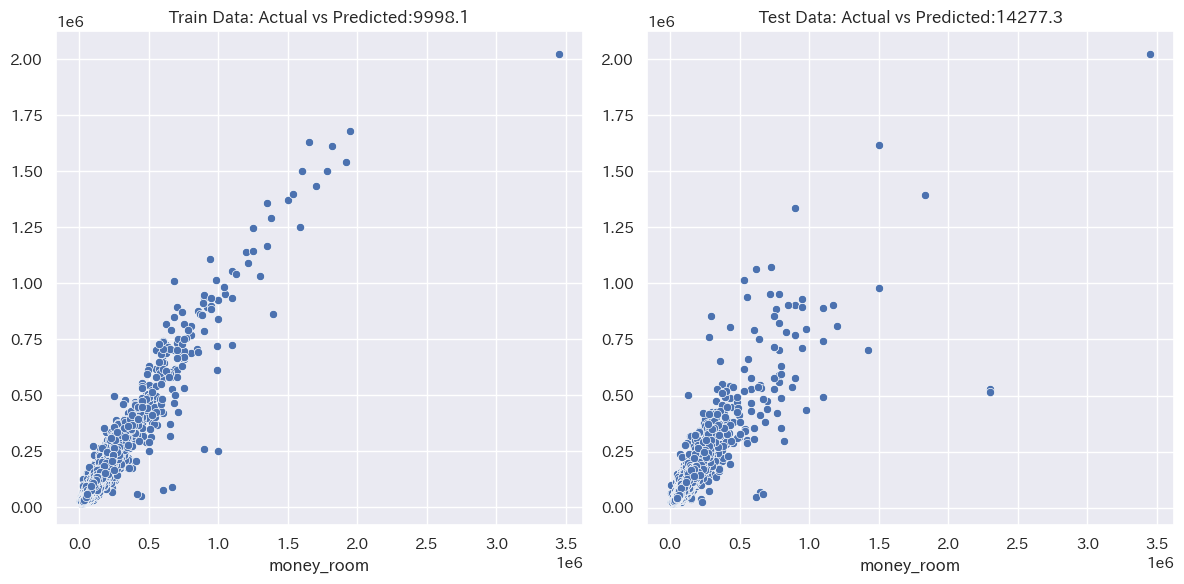

In [27]:
"""
üí°train„Éá„Éº„Çø„ÅÆ‰∫àÊ∏¨Á≤æÂ∫¶„ÅåÁï∞Â∏∏„Å´ËâØ„ÅÑÂ†¥Âêà„ÅØ„Ç™„Éº„Éê„Éº„Éï„Ç£„ÉÉ„ÉÜ„Ç£„É≥„Ç∞„ÅÆÂèØËÉΩÊÄß„Åå„ÅÇ„Çãüí°
"""
# 2„Å§„ÅÆÊï£Â∏ÉÂõ≥„ÇíÊ®™‰∏¶„Å≥„Å´Ë°®Á§∫„Åô„Çã„Åü„ÇÅ„Å´„ÄÅmatplotlib „ÅÆ subplots „Çí‰Ωø„ÅÜ
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1Ë°å2Âàó„ÅÆ„Çµ„Éñ„Éó„É≠„ÉÉ„Éà

# „Çµ„Éñ„Éó„É≠„ÉÉ„Éà1: „Éà„É¨„Éº„Éã„É≥„Ç∞„Éá„Éº„Çø„ÅÆÊï£Â∏ÉÂõ≥
sns.scatterplot(x=df_y_train, y=y_pred_train, ax=axes[0])
axes[0].set_title(f'Train Data: Actual vs Predicted:{round(rmse_train,1)}')  # „Çø„Ç§„Éà„É´„ÇíËøΩÂä†
# „Çµ„Éñ„Éó„É≠„ÉÉ„Éà1: „ÉÜ„Çπ„Éà„Éá„Éº„Çø„ÅÆÊï£Â∏ÉÂõ≥
sns.scatterplot(x=df_y_test, y=y_pred, ax=axes[1])
axes[1].set_title(f'Test Data: Actual vs Predicted:{round(rmse,1)}')  # „Çø„Ç§„Éà„É´„ÇíËøΩÂä†

# „É¨„Ç§„Ç¢„Ç¶„ÉàË™øÊï¥
plt.tight_layout()

# ÁîªÂÉè„Å®„Åó„Å¶‰øùÂ≠ò
plt.savefig(predict_result_plot_file, format="jpg", dpi=300)

# „Éó„É≠„ÉÉ„Éà„ÇíË°®Á§∫
plt.show()


In [28]:
#notebookÂÜÖ„ÅßJavascript„ÇíÂãï„Åã„Åô„Åü„ÇÅ„ÅÆ„Åä„Åæ„Åò„Å™„ÅÑ
shap.initjs()
#TreeExplainer„ÅØ„ÄÅÊ±∫ÂÆöÊú®Á≥ª„ÅÆ„É¢„Éá„É´„ÅÆSHAPÂÄ§„ÇíÂèñÂæó„Åô„Çã„ÇÇ„ÅÆ„ÄÇ
X_test_shap = df_x_test.copy().reset_index(drop=True)
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(X=X_test_shap)
#base_shap_value„Å´ÂØæ„Åó„Å¶„ÄÅÂêÑÂ§âÊï∞„ÅÆshap„Çπ„Ç≥„Ç¢√óÂ§âÊï∞„ÅÆÂÄ§„ÇíÊéõ„ÅëÂêà„Çè„Åõ„ÅüÂÄ§„Åå‰∫àÊ∏¨ÂÄ§„Å´„Å™„Çã„ÄÇ
print("base_shap_value",explainer.expected_value)


base_shap_value 60308.42326619334


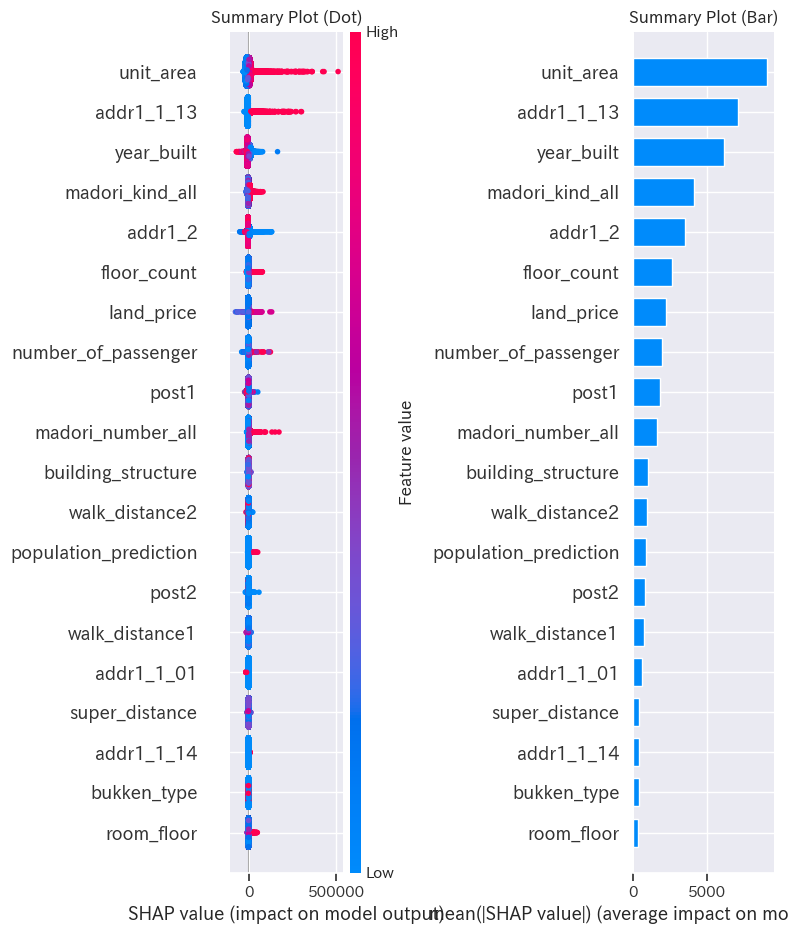

In [29]:
# „Çµ„Éñ„Éó„É≠„ÉÉ„Éà„ÅÆ‰ΩúÊàêÔºàÊ≠£ÊñπÂΩ¢„Å´Ë®≠ÂÆöÔºâ
fig, axes = plt.subplots(1, 2, figsize=(10, 10))  # 1Ë°å2Âàó„ÅÆ„Çµ„Éñ„Éó„É≠„ÉÉ„Éà„ÄÅÊ≠£ÊñπÂΩ¢

# Â∑¶ÂÅ¥„ÅÆÂõ≥: summary_plot
plt.sca(axes[0])  # Â∑¶ÂÅ¥„ÅÆ„Çµ„Éñ„Éó„É≠„ÉÉ„Éà„Çí„Ç¢„ÇØ„ÉÜ„Ç£„Éñ„Å´
shap.summary_plot(shap_values, X_test_shap, plot_type='dot', show=False)
axes[0].set_title("Summary Plot (Dot)", fontsize=12)

# Âè≥ÂÅ¥„ÅÆÂõ≥: bar plot
plt.sca(axes[1])  # Âè≥ÂÅ¥„ÅÆ„Çµ„Éñ„Éó„É≠„ÉÉ„Éà„Çí„Ç¢„ÇØ„ÉÜ„Ç£„Éñ„Å´
shap.summary_plot(shap_values, X_test_shap, plot_type='bar', show=False)
axes[1].set_title("Summary Plot (Bar)", fontsize=12)

# „É¨„Ç§„Ç¢„Ç¶„ÉàË™øÊï¥
plt.tight_layout()

# ÁîªÂÉè„Å®„Åó„Å¶‰øùÂ≠ò
plt.savefig(shap_plot_file, format="jpg", dpi=300)

# „Éó„É≠„ÉÉ„Éà„ÇíË°®Á§∫
plt.show()


#### 5.create submit.csv

In [30]:
#submit

# Ë©ï‰æ°Áî®„Éá„Éº„Çø„ÅßË≥ÉÊñô„Çí‰∫àÊ∏¨
df_test_model_x = df_test
df_test_model_x = pd.get_dummies(df_test_model_x, dtype='int')

y_pred = model.predict(df_test_model_x)

# y_pred„Åã„Çâ„Éá„Éº„Çø„Éï„É¨„Éº„É†„Çí‰ΩúÊàê
pred_df = pd.DataFrame(y_pred, columns=['money_room'])

# pred_df„ÇíCSVÂá∫Âäõ„ÄÅ„Éò„ÉÉ„ÉÄ„Éº„Å™„Åó
pred_df.to_csv(submit_file, index=True, header=False)

# ‰∫àÊ∏¨ÂÄ§„ÇíÁ¢∫Ë™ç
display(pred_df.head())

money_room
0    65950.06
1    53738.39
2    58312.04
3    48117.99
4    71678.18

In [31]:
len(pred_df)

384540